# Illustrate spatial filtering for POP data & obs

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import xarray as xr
from xgcm import Grid
#from dask.diagnostics import ProgressBar
import filter
#import palettable
#from dask.distributed import Client

## Open POP 0.1 degree data

In [2]:
ds = xr.open_dataset('/glade/work/igrooms/current_data', decode_times=False)

### The only loaded time slice is a 5-day average

In [3]:
ds['time_bound'].values

array([[12370., 12375.]])

### Make ocean ("wet") masks

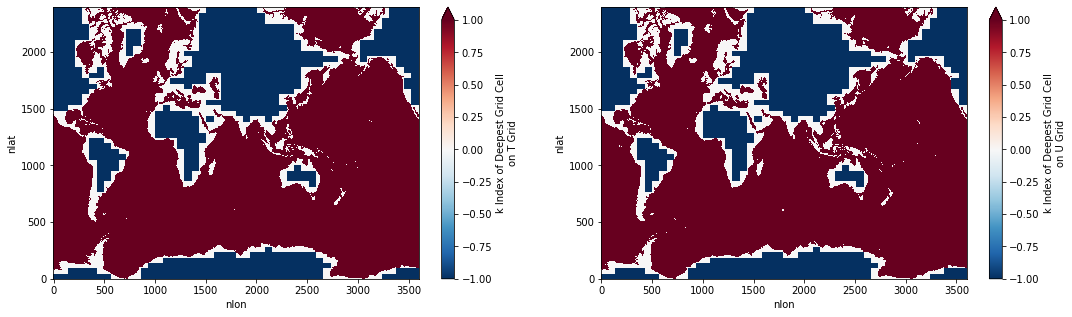

In [4]:
fig,axs = plt.subplots(1,2,figsize=(18,5))
ds.KMT.plot(ax=axs[0],vmin=ds.KMT.min())
ds.KMU.plot(ax=axs[1],vmin=ds.KMU.min())

In [5]:
wet_mask = xr.where(ds['KMT']>0,1,0)
wetu_mask = xr.where(ds['KMU']>0,1,0)

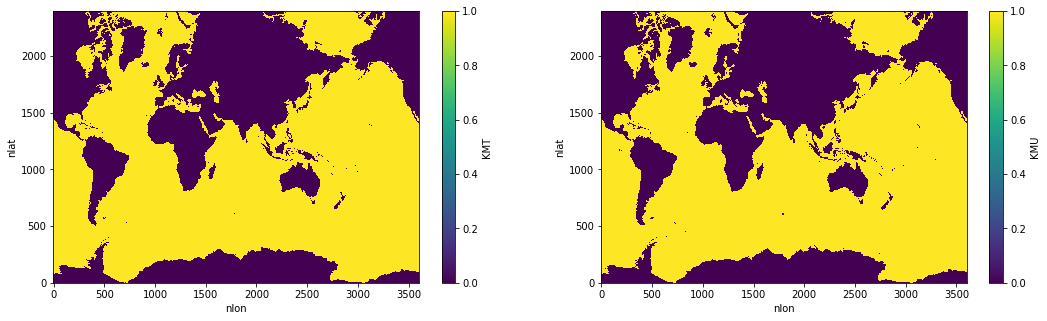

In [6]:
fig,axs = plt.subplots(1,2,figsize=(18,5))
wet_mask.plot(ax=axs[0])
wetu_mask.plot(ax=axs[1])

## Plot a few 2D fields from the POP data set

### SST

In [7]:
SST = ds['TEMP'].isel(z_t=0)
SST = xr.where(wet_mask==1,SST,np.nan)

# compute min & max
Tmin = np.nanmin(SST)
Tmax = np.nanmax(SST)
print('SST: min = %g, max = %g' % (Tmin,Tmax))

SST: min = -3.01017, max = 32.0709


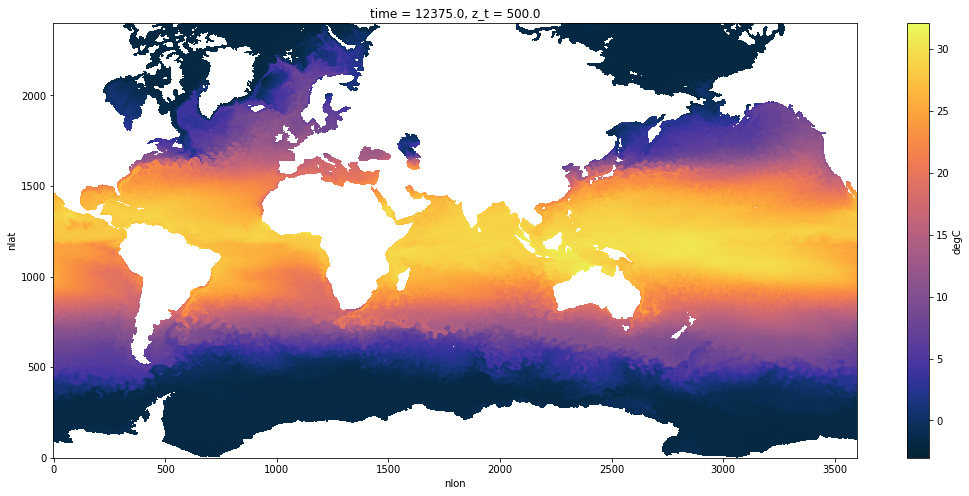

In [8]:
SST.plot(cmap=cmocean.cm.thermal, figsize=(18,8),
         vmin=Tmin,vmax=Tmax, 
         cbar_kwargs={"label": ds.TEMP.units},
        )

### SSS

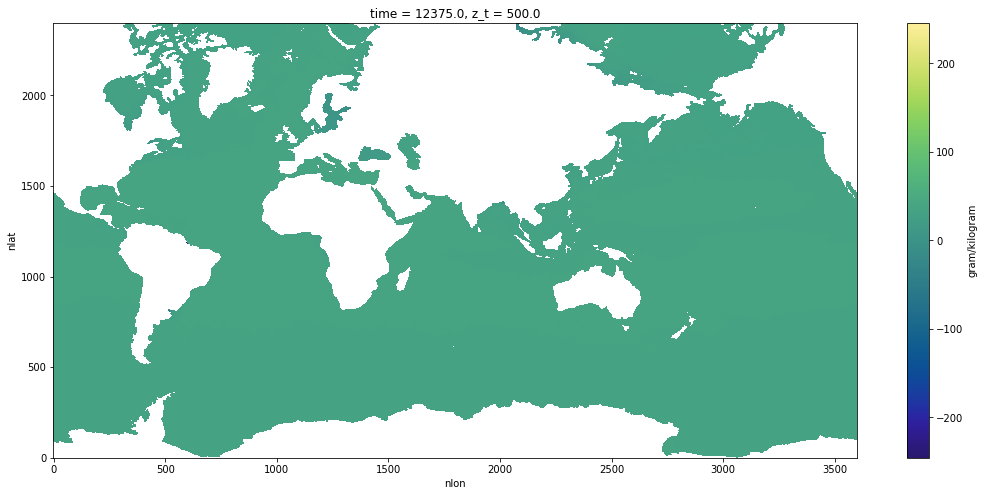

In [9]:
SSS = ds['SALT'].isel(z_t=0)
SSS = xr.where(wet_mask==1,SSS,np.nan)

SSS.plot(cmap=cmocean.cm.haline, figsize=(18,8),
                cbar_kwargs={"label": ds.SALT.units}
            )

SSS seems to have negative values - weird! Let's see where negative values are taken:

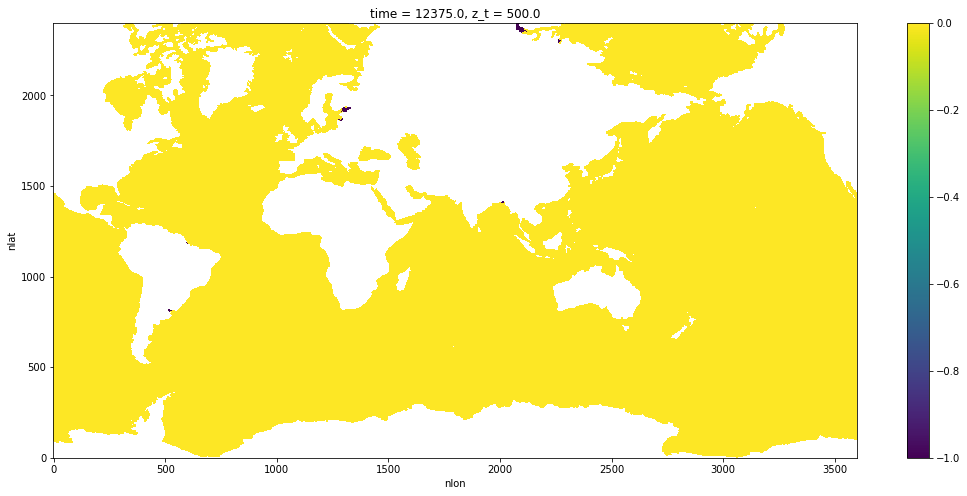

In [10]:
mask = xr.where(SSS>0,0,SSS)
mask = xr.where(mask<0,-1,mask)
mask.plot(figsize=(18,8))

Negative values appear in the Río de la Plata estuary, the Amazon river outlet, near St. Petersburg, and some Siberian rivers outlets in the Arctic. We would expect small positive values for SSS at these locations, but negative values are unphysical?!

### SSH and $(\text{SSH})^2$

[Text(0.5, 1.0, 'SSH squared')]

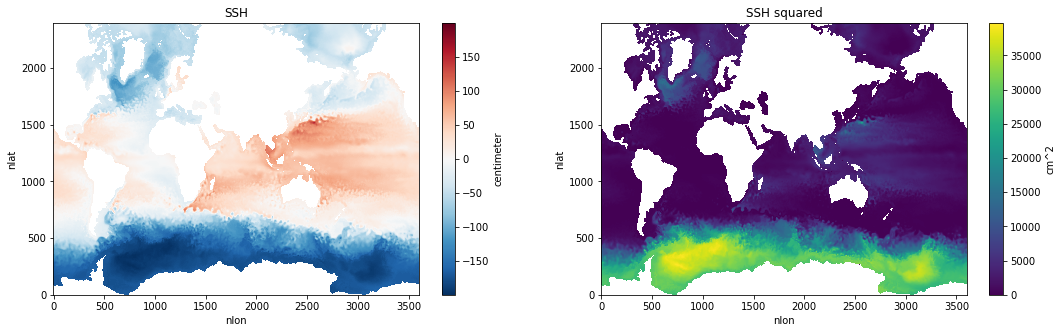

In [11]:
SSH = xr.where(wet_mask==1,ds['SSH'],np.nan)
SSH2 = xr.where(wet_mask==1,ds['SSH2'],np.nan)

fig,axs = plt.subplots(1,2,figsize=(18,5))
SSH.plot(ax=axs[0],cbar_kwargs={"label": ds.SSH.units})
SSH2.plot(ax=axs[1],cbar_kwargs={"label": ds.SSH2.units})
axs[0].set(title='SSH')
axs[1].set(title='SSH squared')

# Define spatial filters

We will test two different filter shapes: Gaussian and Taper

In [12]:
filter_fac=10

### Gaussian

# Laplacian steps: 18; # Biharmonic steps: 1


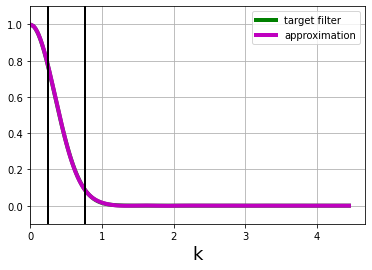

In [13]:
Lf_g = filter_fac/np.sqrt(6) 
N_g=20
NL_g, sL_g, NB_g, sB_g = filter.filterSpec(N_g, 1, Lf_g, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))

### Taper

# Laplacian steps: 38; # Biharmonic steps: 1


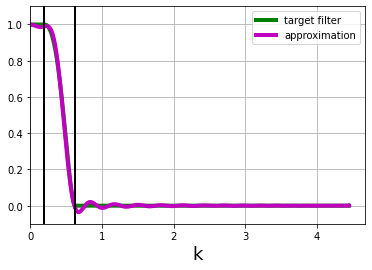

In [14]:
Lf_t = filter_fac/2
N_t=40
NL_t, sL_t, NB_t, sB_t = filter.filterSpec(N_t, 1, Lf_t, 'Taper')
print('# Laplacian steps: ' + str(NL_t) + '; # Biharmonic steps: ' + str(NB_t))

## Fixed coarsening factor

First, we apply filters with a **fixed coarsening factor**, i.e., filters whose scale varies according to the local grid scale. This filter type can be implemented by using a very simple Laplacian on a uniform grid.
For a uniform grid (dx = dy = 1), the finite volume Laplacian simplifies to
$$
    (\Delta f)_{i,j} = -c \cdot f_{i,j} + f_{i-1,j} + f_{i+1,j} + f_{i,j-1} + f_{i,j+1},
$$
where 
\begin{align*}
c=\begin{cases}4 &  \text{wet interior points}\\
               3 & \text{wet edge points}\\
               2 & \text{wet corner points}
               \end{cases}
\end{align*}
and $f=0$ on land points.

In [15]:
try:
    from cupy import get_array_module as _get_array_module
except ImportError:
    import numpy as np

    def _get_array_module(*args):
        return np

**Note**: The following Laplacian assumes periodic boundary conditions. For the global POP data, this is the correct assumption in x-direction. For the y-direction, this is incorrect. Rather than communicating with the southern boundary, the POP tripolar grid **requires communication along the northern boundary of the grid** in order to “sew up” the grid along the line between the two northern grid poles. **This remains to be implemented!** The following Laplacian does the right thing away from the Arctic.

In [16]:
def simple_Laplacian(phi,wetMask):
    np = _get_array_module(phi)

    out = phi.copy()
    out = np.nan_to_num(out) 
    out = wetMask * out 
    
    fac = (np.roll(wetMask, -1, axis=-1) 
            + np.roll(wetMask, 1, axis=-1) 
            + np.roll(wetMask, -1, axis=-2) 
            + np.roll(wetMask, 1, axis=-2)  
    )
        
    out = (- fac * out
            + np.roll(out, -1, axis=-1) 
            + np.roll(out, 1, axis=-1) 
            + np.roll(out, -1, axis=-2) 
            + np.roll(out, 1, axis=-2)
    )
        
    out = wetMask * out
    return out

In [17]:
def apply_gaussian_filter(field,wetMask):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_g):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_g[i])*tempL # Update filtered field
    for i in range(NB_g): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_g[i])/np.abs(sB_g[i])**2)*tempL + (1/np.abs(sB_g[i])**2)*tempB
        
    return fieldBar

In [18]:
def apply_taper_filter(field,wetMask):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_t):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_t[i])*tempL # Update filtered field
    for i in range(NB_t): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_t[i])/np.abs(sB_t[i])**2)*tempL + (1/np.abs(sB_t[i])**2)*tempB
        
    return fieldBar

## Filter 2D fields

In [19]:
ds_ff_g = xr.Dataset() # new xarray dataset for Gaussian-filtered fields with Fixed (coarsening) Factor
ds_ff_t = xr.Dataset() # new xarray dataset for Taper-filtered fields Fixed (coarsening) Factor

for fld in ds.dims:
    ds_ff_g[fld] = ds[fld]
    ds_ff_t[fld] = ds[fld]

Before we start, save SST as extra variable in ds:

In [20]:
ds['SST'] = ds['TEMP'].isel(z_t=0)

Fill the fields to be filtered with nan's on land:

In [21]:
fldlist = ['SST','SSH','SSH2']
for fld in fldlist:
    ds[fld] = xr.where(wet_mask==1,ds[fld],np.nan)

### T-fields

In [24]:
fldlist = ['SST','SSH','SSH2']

dims = ['nlat', 'nlon']

# Gaussian filter, boundary-aware
for fld in fldlist:   
    dataBar = ds[fld].copy() # Initialize the filtering process
    dataBar = dataBar * ds['TAREA'] # multiply by cell area
    #dataBar.data = dataBar.data.map_blocks(cp.asarray) # send to GPU

    dataBar = xr.apply_ufunc(apply_gaussian_filter,
                            dataBar, wet_mask,
                            input_core_dims=[dims,dims],
                            output_core_dims=[dims],
                            output_dtypes=[dataBar.dtype],
                            dask='parallelized'
    )

    #dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
    dataBar = xr.where(wet_mask,dataBar,np.nan) # mask by nan's if on land
    dataBar = dataBar/ds['TAREA'] # divide by cell area    
            
    ds_ff_g[fld] = dataBar.copy()

# Taper filter, boundary-aware
for fld in fldlist:   
    dataBar = ds[fld].copy() # Initialize the filtering process
    dataBar = dataBar * ds['TAREA'] # multiply by cell area
    #dataBar.data = dataBar.data.map_blocks(cp.asarray) # send to GPU

    dataBar = xr.apply_ufunc(apply_taper_filter,
                            dataBar, wet_mask,
                            input_core_dims=[dims,dims],
                            output_core_dims=[dims],
                            output_dtypes=[dataBar.dtype],
                            dask='parallelized'
    )

    #dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
    dataBar = xr.where(wet_mask,dataBar,np.nan) # mask by nan's if on land
    dataBar = dataBar/ds['TAREA'] # divide by cell area    
            
    ds_ff_t[fld] = dataBar.copy()

### Plot unfiltered vs. filtered field: global

[Text(0.5, 1.0, 'filtered SSH: Sharp filter')]

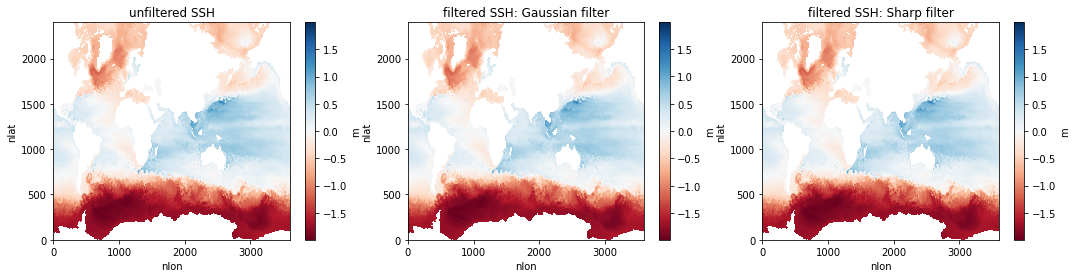

In [32]:
fld = 'SSH'
#fld = 'SST'
#Tmin = min(np.min(ds[fld]),np.min(ds_ff_g[fld]),np.min(ds_ff_t[fld]))
#Tmax = max(np.max(ds[fld]),np.max(ds_ff_g[fld]),np.max(ds_ff_t[fld]))

fig,axs = plt.subplots(1,3,figsize=(18,4))
(0.01*ds[fld]).plot(ax=axs[0],cmap='RdBu_r',cbar_kwargs={"label": 'm'}) 
             #vmin=Tmin,vmax=Tmax,cmap=cmocean.cm.thermal,

(0.01*ds_ff_g[fld]).plot(ax=axs[1],cmap='RdBu_r',cbar_kwargs={"label": 'm'}) 
                  #vmin=Tmin,vmax=Tmax,cmap=cmocean.cm.thermal, 

(0.01*ds_ff_t[fld]).plot(ax=axs[2],cmap='RdBu_r',cbar_kwargs={"label": 'm'}) 
                  #vmin=Tmin,vmax=Tmax,cmap=cmocean.cm.thermal

axs[0].set(title='unfiltered %s' %(fld))
axs[1].set(title='filtered %s: Gaussian filter' %(fld))
axs[2].set(title='filtered %s: Sharp filter' %(fld))

Can't see much - let's move to regional plots

### Example: Gulf Stream region (we could change this to anywhere else)

[Text(0.5, 1.0, 'filtered SSH: Sharp filter')]

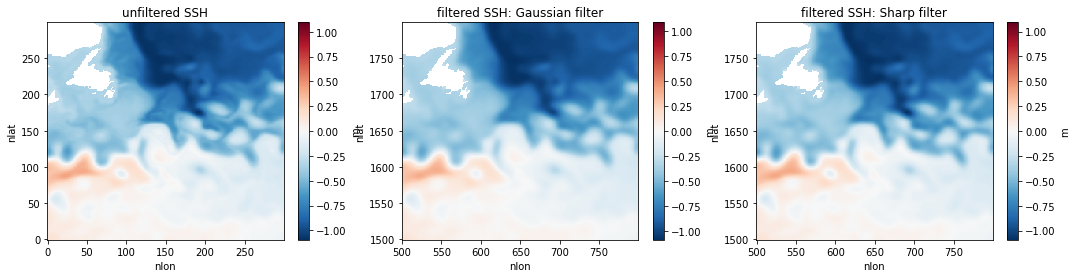

In [33]:
fld = 'SSH'
#fld = 'SST'
#Tmin = min(np.min(ds[fld]),np.min(ds_ff_g[fld]),np.min(ds_ff_t[fld]))
#Tmax = max(np.max(ds[fld]),np.max(ds_ff_g[fld]),np.max(ds_ff_t[fld]))

fig,axs = plt.subplots(1,3,figsize=(18,4))
(0.01*ds[fld]).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0],cmap='RdBu_r',cbar_kwargs={"label": 'm'}) 
             #vmin=Tmin,vmax=Tmax,cmap=cmocean.cm.thermal,

(0.01*ds_ff_g[fld]).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1],cmap='RdBu_r',cbar_kwargs={"label": 'm'}) 
                  #vmin=Tmin,vmax=Tmax,cmap=cmocean.cm.thermal, 

(0.01*ds_ff_t[fld]).isel(nlon=xslice,nlat=yslice).plot(ax=axs[2],cmap='RdBu_r',cbar_kwargs={"label": 'm'}) 
                  #vmin=Tmin,vmax=Tmax,cmap=cmocean.cm.thermal

axs[0].set(title='unfiltered %s' %(fld))
axs[1].set(title='filtered %s: Gaussian filter' %(fld))
axs[2].set(title='filtered %s: Sharp filter' %(fld))

## Nicer lat/lon grid (on which we will also plot the obs)

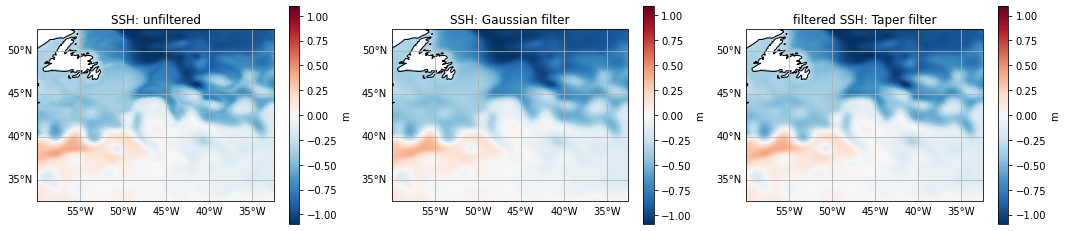

In [38]:
import matplotlib.ticker as mticker

fig,axs = plt.subplots(1,3,figsize=(18,4),subplot_kw={'projection':ccrs.PlateCarree()})
        
(0.01*ds['SSH']).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0],x='ULONG',y='ULAT',
                                                    cmap='RdBu_r',transform=ccrs.PlateCarree(),
                                                    cbar_kwargs={"label": 'm'})


(0.01*ds_ff_g['SSH']).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1],x='ULONG',y='ULAT',
                                                    cmap='RdBu_r',transform=ccrs.PlateCarree(),
                                                    cbar_kwargs={"label": 'm'})

(0.01*ds_ff_t['SSH']).isel(nlon=xslice,nlat=yslice).plot(ax=axs[2],x='ULONG',y='ULAT',
                                                    cmap='RdBu_r',transform=ccrs.PlateCarree(),
                                                    cbar_kwargs={"label": 'm'})
axs[0].set(title='SSH: unfiltered')
axs[1].set(title='SSH: Gaussian filter')
axs[2].set(title='filtered SSH: Taper filter')
#ax = plt.axes(facecolor='k', projection=ccrs.PlateCarree())

#axs[0].scatter(ds['ULONG'].isel(nlon=xslice,nlat=yslice), ds['ULAT'].isel(nlon=xslice,nlat=yslice), 
               #transform=ccrs.PlateCarree())
for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent([-60, -32.5, 32.5, 52.5], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator([35, 40, 45, 50])
#plt.savefig('figures/EKE_gulfstream_new.png',dpi=200,bbox_inches='tight',pad_inches=0)

@Jake: SSH has a pretty smooth structure already so that the filtering doesn't do much. Should we choose a different field, or a larger coarsening factor?